In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator
import cv2
import os
import seaborn as sns
from skimage import color

import warnings
warnings.filterwarnings("ignore")

### Plot masks overlay

In [2]:
# Full mammogram scan
full_img = cv2.imread("../data/preprocessed/Mass/Test_FULL/P_01668_LEFT_MLO_FULL___PRE.png", cv2.IMREAD_GRAYSCALE)
full_img = cv2.resize(src=full_img, dsize=(224, 224))

# Ground truth
true_mask = cv2.imread("../data/preprocessed/Mass/Test_MASK/P_01668_LEFT_MLO_MASK_1___PRE.png", cv2.IMREAD_GRAYSCALE)
true_mask = cv2.resize(src=true_mask, dsize=(224, 224))

# Predicted mask
pred_mask = cv2.imread("../results/fit/20201203_040325___INSTANCE/predicted_outputs/predmask_only/P_01668_LEFT_MLO_FULL___PREDICTED.png", cv2.IMREAD_GRAYSCALE)
pred_mask = cv2.resize(src=pred_mask, dsize=(224, 224))


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

# Method 1: OpenCV
# ----------------

# Stack to create RGB version of grayscale images.
full_img_rgb = np.stack([full_img, full_img, full_img], axis=-1)
true_mask_rgb = np.stack([np.zeros_like(true_mask), true_mask, np.zeros_like(true_mask)], axis=-1)
pred_mask_rgb = np.stack([pred_mask, np.zeros_like(pred_mask), np.zeros_like(pred_mask)], axis=-1)

overlay_masks = cv2.addWeighted(src1=true_mask_rgb, alpha=0.5, src2=pred_mask_rgb, beta=1, gamma=0)
overlay_all = cv2.addWeighted(src1=full_img_rgb, alpha=1, src2=overlay_masks, beta=0.5, gamma=0)

ax[0][0].imshow(true_mask_rgb)
ax[0][1].imshow(pred_mask_rgb)
ax[0][2].imshow(overlay_masks)
ax[1][0].imshow(overlay_all)


# Method 2: Matplotlib alpha
# --------------------------

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

bwr_cmap = plt.get_cmap("bwr")
true_cmap = truncate_colormap(cmap=bwr_cmap, minval=0.5, maxval=1.0)
pred_cmap = truncate_colormap(cmap=bwr_cmap, minval=0.5, maxval=0)

ax[1][1].imshow(true_mask, cmap=true_cmap, alpha=0.3)
ax[1][1].imshow(pred_mask, cmap=pred_cmap, alpha=0.3)

ax[1][2].imshow(full_img, cmap="gray", alpha=1)
ax[1][2].imshow(true_mask, cmap=true_cmap, alpha=0.3)
ax[1][2].imshow(pred_mask, cmap=pred_cmap, alpha=0.3)

error: OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-b4ibzwe2/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


### Read .csv

In [82]:
df = pd.read_csv("../data/csv/Mass_test.csv")
iou_df = pd.read_csv("../results/fit/20201203_040325___INSTANCE/predicted_outputs/IOUs/iou.csv")

# Rename patient_id to identifier in iou_df.
iou_df.rename(columns={"patient_id":"identifier"}, inplace=True)

### Insert IoU into `Mass_test.csv`

In [84]:
df = pd.merge(left=df, right=iou_df, how="outer", on="identifier")

In [85]:
df.head()

,identifier,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,iouMetric
0,P_00001_LEFT_MLO,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,0.169870
1,P_00004_RIGHT_MLO,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,0.260022
2,P_00018_RIGHT_CC,P_00018,2,RIGHT,CC,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,0.292330
3,P_00021_RIGHT_CC,P_00021,1,RIGHT,CC,1,mass,OVAL,CIRCUMSCRIBED,3,BENIGN,5,0.214917
4,P_00023_RIGHT_CC,P_00023,1,RIGHT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,4,0.377711


### Explore >1 masses

In [86]:
df["identifier"].value_counts().loc[lambda x: x>1] 

P_01566_RIGHT_MLO    3
P_00106_LEFT_CC      3
P_01343_LEFT_CC      2
P_00419_LEFT_CC      2
P_01596_RIGHT_MLO    2
P_00710_LEFT_CC      2
P_00778_RIGHT_CC     2
Name: identifier, dtype: int64

In [87]:
masses = ["P_01566_RIGHT_MLO", "P_00106_LEFT_CC", "P_01343_LEFT_CC", "P_00419_LEFT_CC", "P_01596_RIGHT_MLO", "P_00710_LEFT_CC", "P_00778_RIGHT_CC"]

df[df["identifier"].isin(masses)]

,identifier,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,iouMetric
8,P_00106_LEFT_CC,P_00106,1,LEFT,CC,1,mass,LYMPH_NODE,CIRCUMSCRIBED,2,BENIGN_WITHOUT_CALLBACK,4,0.001249
9,P_00106_LEFT_CC,P_00106,1,LEFT,CC,2,mass,LYMPH_NODE,CIRCUMSCRIBED,2,BENIGN_WITHOUT_CALLBACK,4,0.001249
10,P_00106_LEFT_CC,P_00106,1,LEFT,CC,3,mass,LYMPH_NODE,CIRCUMSCRIBED,2,BENIGN_WITHOUT_CALLBACK,4,0.001249
24,P_00419_LEFT_CC,P_00419,2,LEFT,CC,1,mass,OVAL,CIRCUMSCRIBED,3,BENIGN,5,0.275678
25,P_00419_LEFT_CC,P_00419,2,LEFT,CC,2,mass,NaN,ILL_DEFINED,5,MALIGNANT,5,0.275678
40,P_00710_LEFT_CC,P_00710,2,LEFT,CC,1,mass,ROUND-OVAL,CIRCUMSCRIBED-OBSCURED,4,BENIGN,5,0.377996
41,P_00710_LEFT_CC,P_00710,2,LEFT,CC,2,mass,ROUND-OVAL,CIRCUMSCRIBED-OBSCURED,4,BENIGN,5,0.377996
48,P_00778_RIGHT_CC,P_00778,3,RIGHT,CC,1,mass,ARCHITECTURAL_DISTORTION,NaN,2,BENIGN,3,0.000182
49,P_00778_RIGHT_CC,P_00778,3,RIGHT,CC,2,mass,ARCHITECTURAL_DISTORTION,NaN,2,BENIGN,3,0.000182
86,P_01343_LEFT_CC,P_01343,2,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,5,MALIGNANT,5,0.495915


### Distribution of all IoU

0.20331513362076034
0.18300855159759521


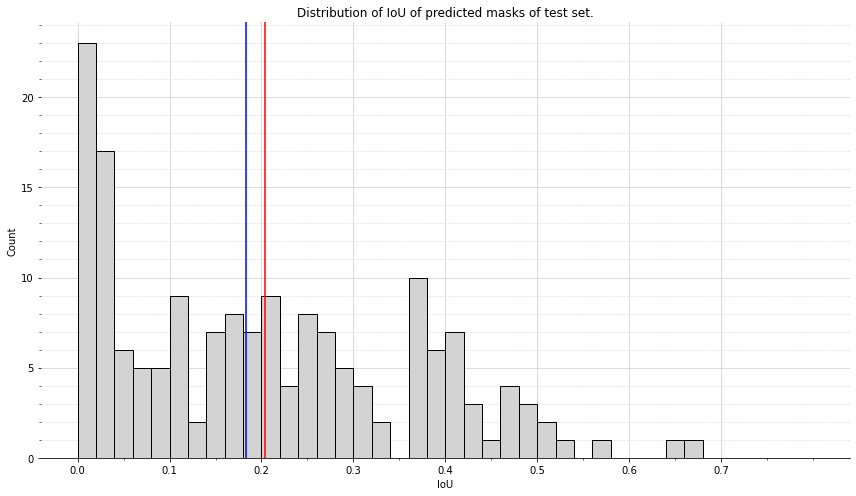

In [394]:
# Create bins for histogram
bins = np.linspace(start=0, stop=0.8, num=41)

avg_iou = df["iouMetric"].mean()
median_iou = df["iouMetric"].median()
print(avg_iou)
print(median_iou)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
ax.hist(df["iouMetric"], color="#d3d3d3", edgecolor="black", bins=bins)

ax.set_title("Distribution of IoU of predicted masks of test set.")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="y", color="#e7e7e7", linestyle="dashed")
ax.set_xlabel("IoU")
ax.set_ylabel("Count")
ax.xaxis.set_ticks(np.arange(0, 0.8, 0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_ticks(np.arange(0, 25, 5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.patch.set_alpha(0)
ax.set_axisbelow(True)

ax.axvline(x=avg_iou, color="red")
ax.axvline(x=median_iou, color="blue")

plt.tight_layout()
plt.savefig(fname="../writeups/visualisations_for_slides/all_iou_mean_median_hist.png", dpi=300)

### Q1: Which `mass_shape` does the model perform best on?


#### Types of mass shapes

In [113]:
df["mass_shape"].value_counts()

LOBULATED                             45
IRREGULAR                             42
OVAL                                  38
ARCHITECTURAL_DISTORTION              12
ROUND                                 10
IRREGULAR-ARCHITECTURAL_DISTORTION     9
LYMPH_NODE                             4
ASYMMETRIC_BREAST_TISSUE               3
ROUND-OVAL                             2
LOBULATED-IRREGULAR                    1
Name: mass_shape, dtype: int64

#### Number of null

In [89]:
df["mass_shape"].isnull().sum()

2

#### Get unique mass shapes and corresponding identifiers.

In [97]:
mass_shapes = dict((shape, []) for shape in df["mass_shape"].unique())

for row in df.itertuples():
    if (row.identifier not in mass_shapes[row.mass_shape]) and (row.mass_shape is not np.nan):
        mass_shapes[row.mass_shape].append(row.identifier)

#### Visualise samples of each mass shape

In [122]:
full_paths = dict((identifier, np.nan) for identifier in df["identifier"].unique())

for curdir, dirs, files in os.walk("../data/preprocessed/Mass/Test_FULL"):
    files.sort()
    for f in files:
        if f.endswith(".png"):
            f_split = f.split("_")
            identifier = "_".join(f_split[:4])
            full_paths[identifier] = os.path.join(curdir, f)
            
mask_paths = dict((identifier, np.nan) for identifier in df["identifier"].unique())

for curdir, dirs, files in os.walk("../data/preprocessed/Mass/Test_MASK"):
    files.sort()
    for f in files:
        if f.endswith(".png"):
            f_split = f.split("_")
            identifier = "_".join(f_split[:4])
            mask_paths[identifier] = os.path.join(curdir, f)

##### Lobulated

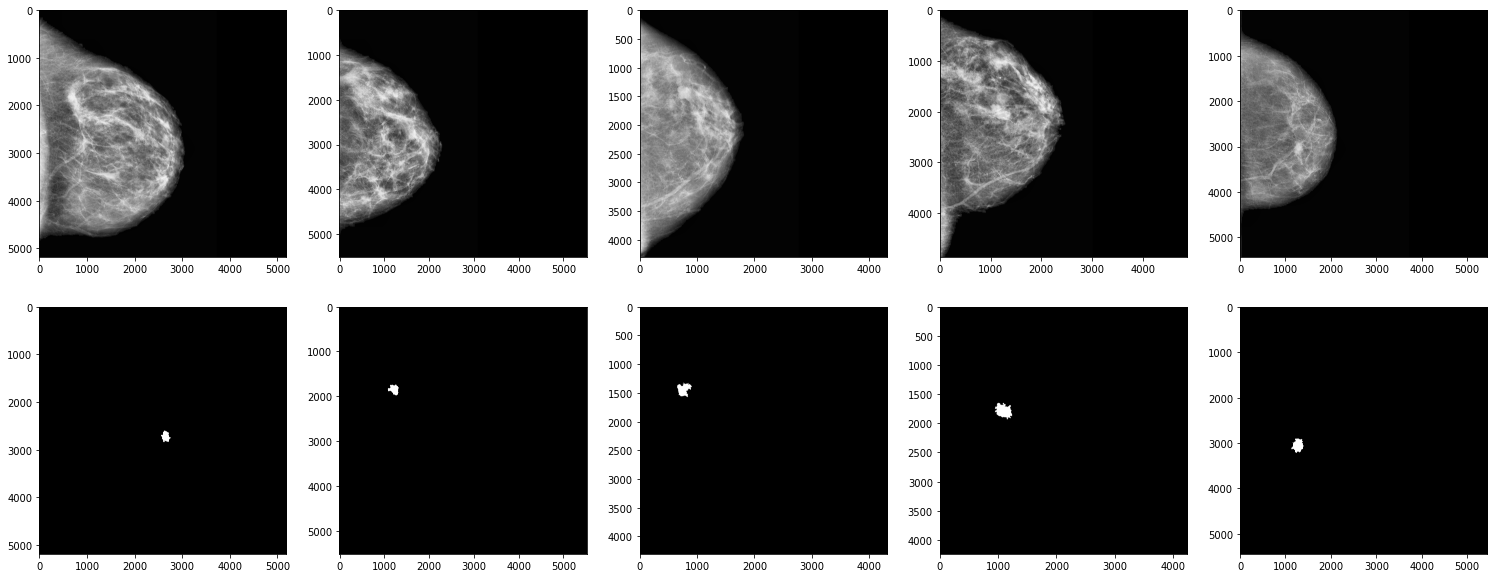

In [124]:
lobulated_paths_full = [full_paths[identifier] for identifier in mass_shapes["LOBULATED"][:5]]
lobulated_paths_mask = [mask_paths[identifier] for identifier in mass_shapes["LOBULATED"][:5]]

fig, ax = plt.subplots(nrows=2, ncols=len(lobulated_paths_full), figsize=(26, 10))

for i in range(len(lobulated_paths_full)):
    
    img = cv2.imread(lobulated_paths_full[i], cv2.IMREAD_GRAYSCALE)
    ax[0][i].imshow(img, cmap="gray")
    
    img = cv2.imread(lobulated_paths_mask[i], cv2.IMREAD_GRAYSCALE)
    ax[1][i].imshow(img, cmap="gray")

In [350]:
good_lobulated = ["P_00399", "P_00581", "P_01712", "P_01739"]
df[df["patient_id"].isin(good_lobulated)]

,identifier,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,iouMetric
22,P_00399_RIGHT_CC,P_00399,1,RIGHT,CC,1,mass,LOBULATED,MICROLOBULATED,5,MALIGNANT,5,0.479470
38,P_00581_LEFT_MLO,P_00581,1,LEFT,MLO,1,mass,LOBULATED,SPICULATED,5,MALIGNANT,5,0.407338
119,P_01712_LEFT_CC,P_01712,1,LEFT,CC,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,0.304544
120,P_01712_RIGHT_CC,P_01712,1,RIGHT,CC,1,mass,LOBULATED,CIRCUMSCRIBED-ILL_DEFINED,4,BENIGN,5,0.402764
122,P_01739_LEFT_CC,P_01739,1,LEFT,CC,1,mass,LOBULATED,OBSCURED,3,BENIGN,5,0.462435
123,P_01739_LEFT_MLO,P_01739,1,LEFT,MLO,1,mass,LOBULATED,OBSCURED,3,BENIGN,5,0.159915


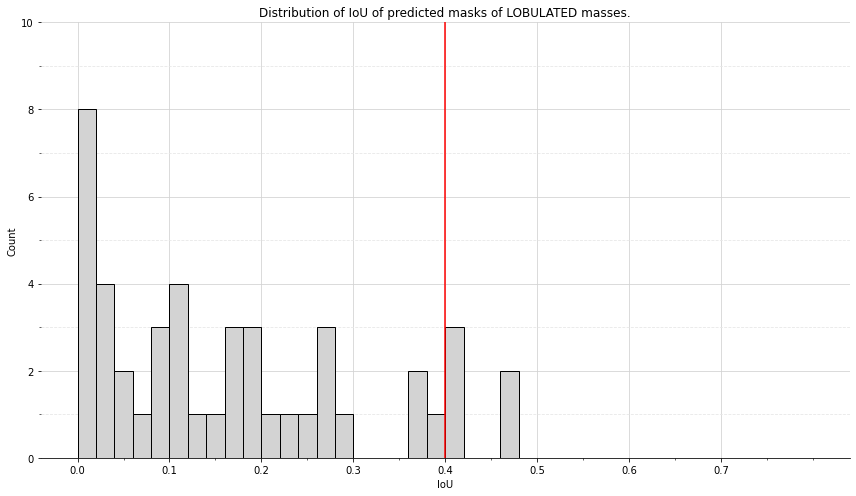

In [378]:
# Create bins for histogram
bins = np.linspace(start=0, stop=0.8, num=41)

# Create separate dataframes for mass shapes
lob_df = df[df["mass_shape"]=="LOBULATED"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
ax.hist(lob_df["iouMetric"], color="#d3d3d3", edgecolor="black", bins=bins)

ax.axvline(x=0.4, color="red")

ax.set_title("Distribution of IoU of predicted masks of LOBULATED masses.")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="y", color="#e7e7e7", linestyle="dashed")
ax.set_xlabel("IoU")
ax.set_ylabel("Count")
ax.xaxis.set_ticks(np.arange(0, 0.8, 0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_ticks(np.arange(0, 12, 2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.patch.set_alpha(0)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(fname="../writeups/visualisations_for_slides/lobulated_hist.png", dpi=300)

In [383]:
# Compute skewness
lob_df["iouMetric"].skew()

0.6584446685352824

##### Irregular

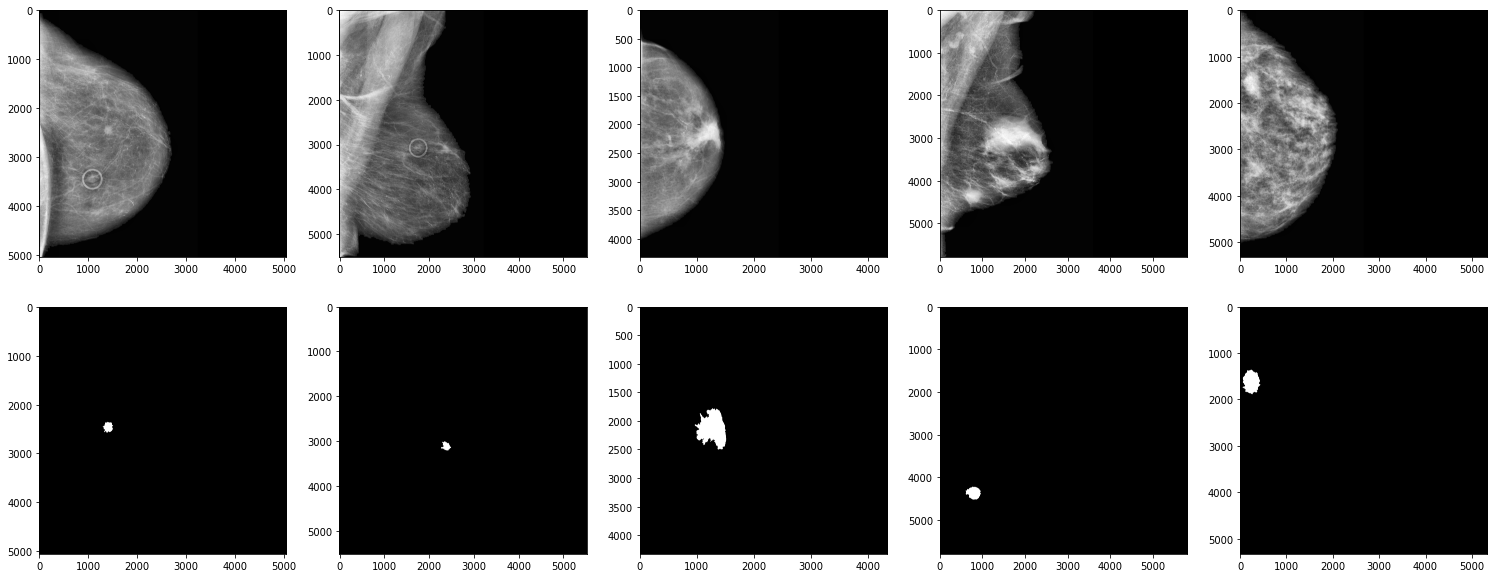

In [125]:
irreg_paths_full = [full_paths[identifier] for identifier in mass_shapes["IRREGULAR"][:5]]
irreg_paths_mask = [mask_paths[identifier] for identifier in mass_shapes["IRREGULAR"][:5]]

fig, ax = plt.subplots(nrows=2, ncols=len(lobulated_paths_full), figsize=(26, 10))

for i in range(len(irreg_paths_full)):
    
    img = cv2.imread(irreg_paths_full[i], cv2.IMREAD_GRAYSCALE)
    ax[0][i].imshow(img, cmap="gray")
    
    img = cv2.imread(irreg_paths_mask[i], cv2.IMREAD_GRAYSCALE)
    ax[1][i].imshow(img, cmap="gray")

In [373]:
good_irregular = ["P_00023", "P_00118", "P_01343", "P_01405"]
df[df["patient_id"].isin(good_irregular)]

,identifier,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,iouMetric
4,P_00023_RIGHT_CC,P_00023,1,RIGHT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,4,0.377711
5,P_00023_RIGHT_MLO,P_00023,1,RIGHT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,4,0.031297
86,P_01343_LEFT_CC,P_01343,2,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,5,MALIGNANT,5,0.495915
87,P_01343_LEFT_CC,P_01343,2,LEFT,CC,2,mass,IRREGULAR,ILL_DEFINED-SPICULATED,4,MALIGNANT,5,0.495915
96,P_01405_RIGHT_CC,P_01405,1,RIGHT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,0.445559
133,P_00118_RIGHT_CC,P_00118,1,RIGHT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,0.409870


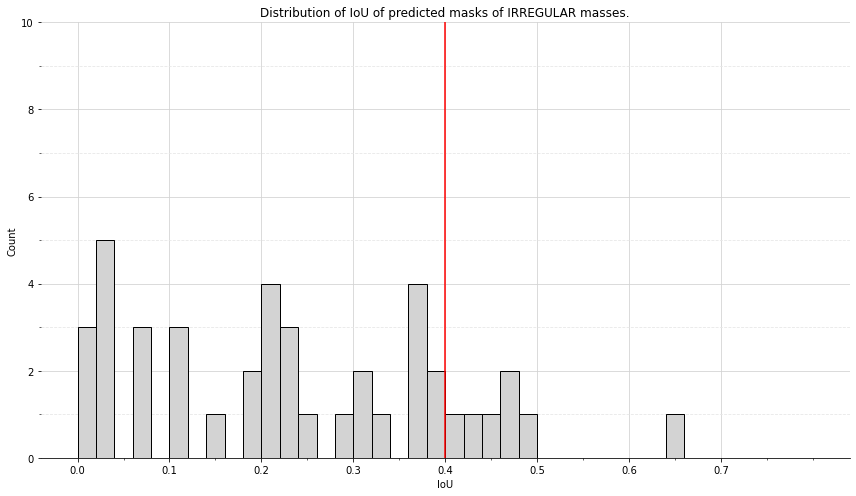

In [379]:
# Create bins for histogram
bins = np.linspace(start=0, stop=0.8, num=41)

# Create separate dataframes for mass shapes
irreg_df = df[df["mass_shape"]=="IRREGULAR"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
ax.hist(irreg_df["iouMetric"], color="#d3d3d3", edgecolor="black", bins=bins)

ax.axvline(x=0.4, color="red")

ax.set_title("Distribution of IoU of predicted masks of IRREGULAR masses.")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="y", color="#e7e7e7", linestyle="dashed")
ax.set_xlabel("IoU")
ax.set_ylabel("Count")
ax.xaxis.set_ticks(np.arange(0, 0.8, 0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_ticks(np.arange(0, 12, 2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.patch.set_alpha(0)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(fname="../writeups/visualisations_for_slides/irregular_hist.png", dpi=300)

In [384]:
# Compute skewness
irreg_df["iouMetric"].skew()

0.3343162686923199

##### Lobulated-irregular

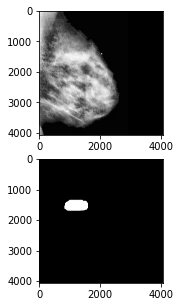

In [133]:
lobIrreg_paths_full = [full_paths[identifier] for identifier in mass_shapes["LOBULATED-IRREGULAR"]]
lobIrreg_paths_mask = [mask_paths[identifier] for identifier in mass_shapes["LOBULATED-IRREGULAR"]]

fig, ax = plt.subplots(nrows=2, ncols=len(lobIrreg_paths_full), figsize=(5, 5))

for i in range(len(lobIrreg_paths_full)):
    
    img = cv2.imread(lobIrreg_paths_full[i], cv2.IMREAD_GRAYSCALE)
    ax[0].imshow(img, cmap="gray")
    
    img = cv2.imread(lobIrreg_paths_mask[i], cv2.IMREAD_GRAYSCALE)
    ax[1].imshow(img, cmap="gray")

##### Oval

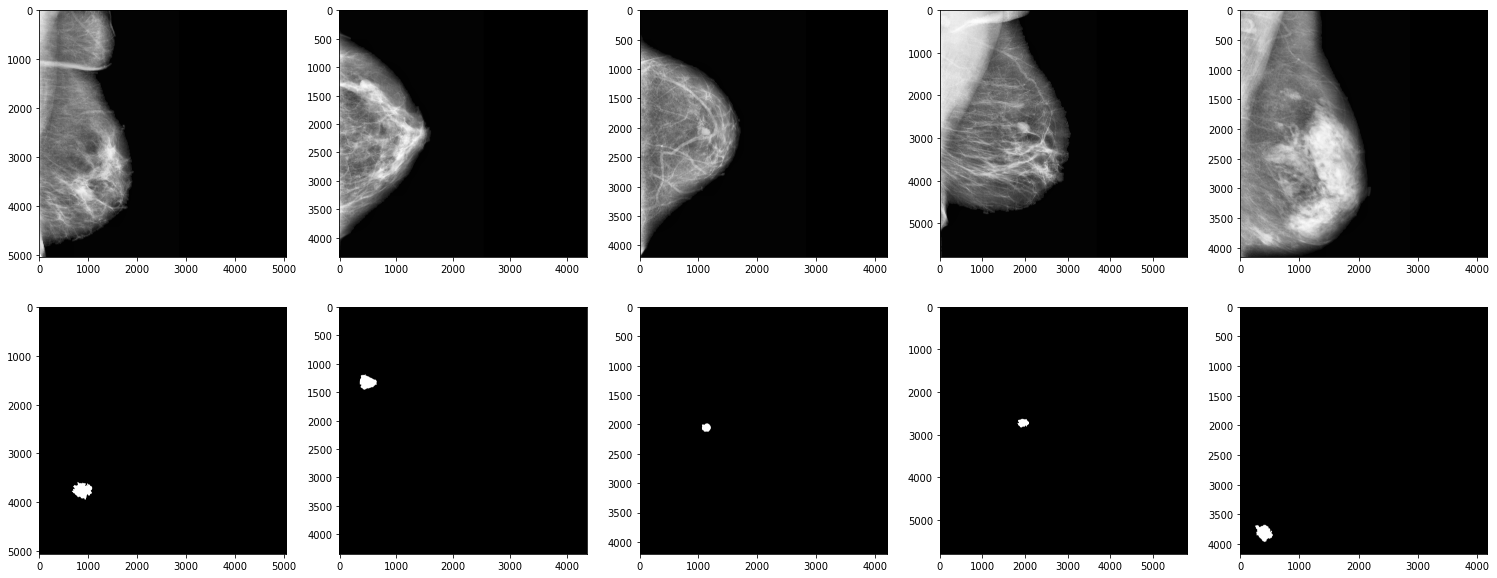

In [126]:
oval_paths_full = [full_paths[identifier] for identifier in mass_shapes["OVAL"][:5]]
oval_paths_mask = [mask_paths[identifier] for identifier in mass_shapes["OVAL"][:5]]

fig, ax = plt.subplots(nrows=2, ncols=len(oval_paths_full), figsize=(26, 10))

for i in range(len(oval_paths_full)):
    
    img = cv2.imread(oval_paths_full[i], cv2.IMREAD_GRAYSCALE)
    ax[0][i].imshow(img, cmap="gray")
    
    img = cv2.imread(oval_paths_mask[i], cv2.IMREAD_GRAYSCALE)
    ax[1][i].imshow(img, cmap="gray")

In [376]:
good_oval = ["P_00524", "P_01082", "P_01596", "P_01735"]
df[df["patient_id"].isin(good_oval)]

,identifier,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,iouMetric
67,P_01082_RIGHT_MLO,P_01082,1,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,0.488231
111,P_01596_RIGHT_MLO,P_01596,2,RIGHT,MLO,1,mass,OVAL,ILL_DEFINED,4,MALIGNANT,5,0.506861
112,P_01596_RIGHT_MLO,P_01596,2,RIGHT,MLO,2,mass,OVAL,ILL_DEFINED,4,MALIGNANT,5,0.506861
121,P_01735_RIGHT_MLO,P_01735,2,RIGHT,MLO,1,mass,OVAL,OBSCURED,0,MALIGNANT,5,0.258418
142,P_00524_LEFT_CC,P_00524,1,LEFT,CC,1,mass,OVAL,CIRCUMSCRIBED,4,MALIGNANT,5,0.392163


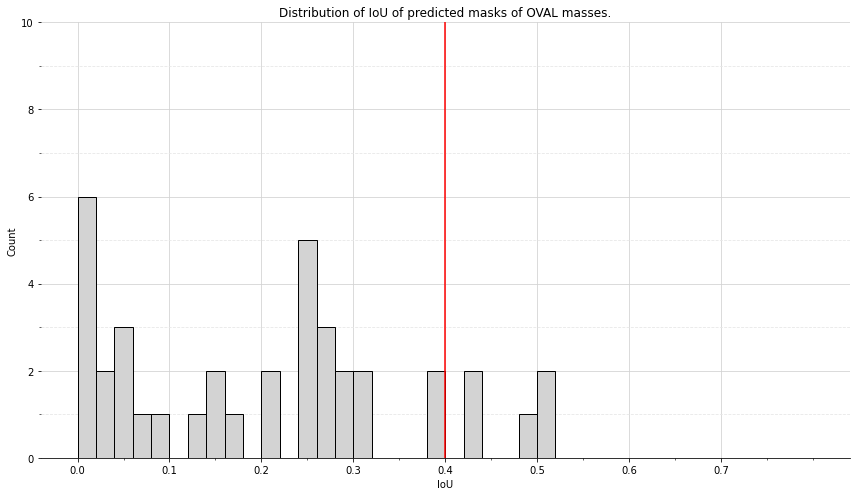

In [380]:
# Create bins for histogram
bins = np.linspace(start=0, stop=0.8, num=41)

# Create separate dataframes for mass shapes
oval_df = df[df["mass_shape"]=="OVAL"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
ax.hist(oval_df["iouMetric"], color="#d3d3d3", edgecolor="black", bins=bins)

ax.axvline(x=0.4, color="red")

ax.set_title("Distribution of IoU of predicted masks of OVAL masses.")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="y", color="#e7e7e7", linestyle="dashed")
ax.set_xlabel("IoU")
ax.set_ylabel("Count")
ax.xaxis.set_ticks(np.arange(0, 0.8, 0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_ticks(np.arange(0, 12, 2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.patch.set_alpha(0)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(fname="../writeups/visualisations_for_slides/oval_hist.png", dpi=300)

In [385]:
# Compute skewness
oval_df["iouMetric"].skew()

0.2977323115831691

##### Architectural distortion

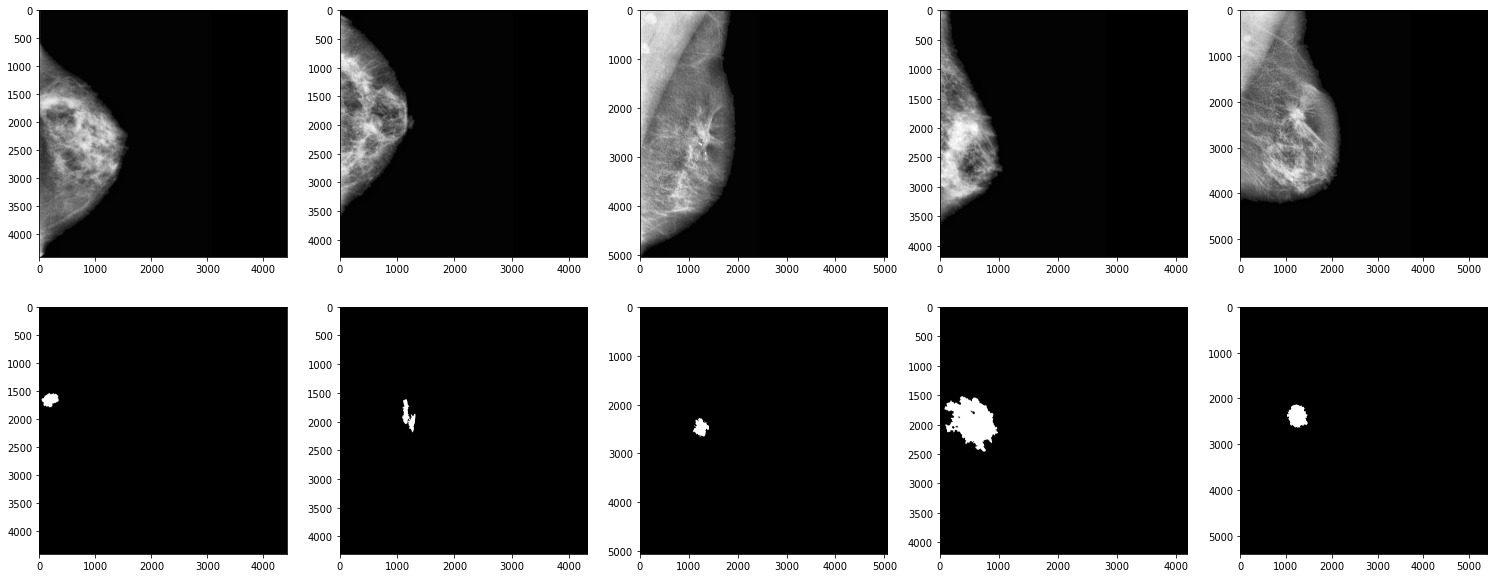

In [130]:
archiDis_paths_full = [full_paths[identifier] for identifier in mass_shapes["ARCHITECTURAL_DISTORTION"][:5]]
archiDis_paths_mask = [mask_paths[identifier] for identifier in mass_shapes["ARCHITECTURAL_DISTORTION"][:5]]

fig, ax = plt.subplots(nrows=2, ncols=len(archiDis_paths_full), figsize=(26, 10))

for i in range(len(archiDis_paths_full)):
    
    img = cv2.imread(archiDis_paths_full[i], cv2.IMREAD_GRAYSCALE)
    ax[0][i].imshow(img, cmap="gray")
    
    img = cv2.imread(archiDis_paths_mask[i], cv2.IMREAD_GRAYSCALE)
    ax[1][i].imshow(img, cmap="gray")

##### Round

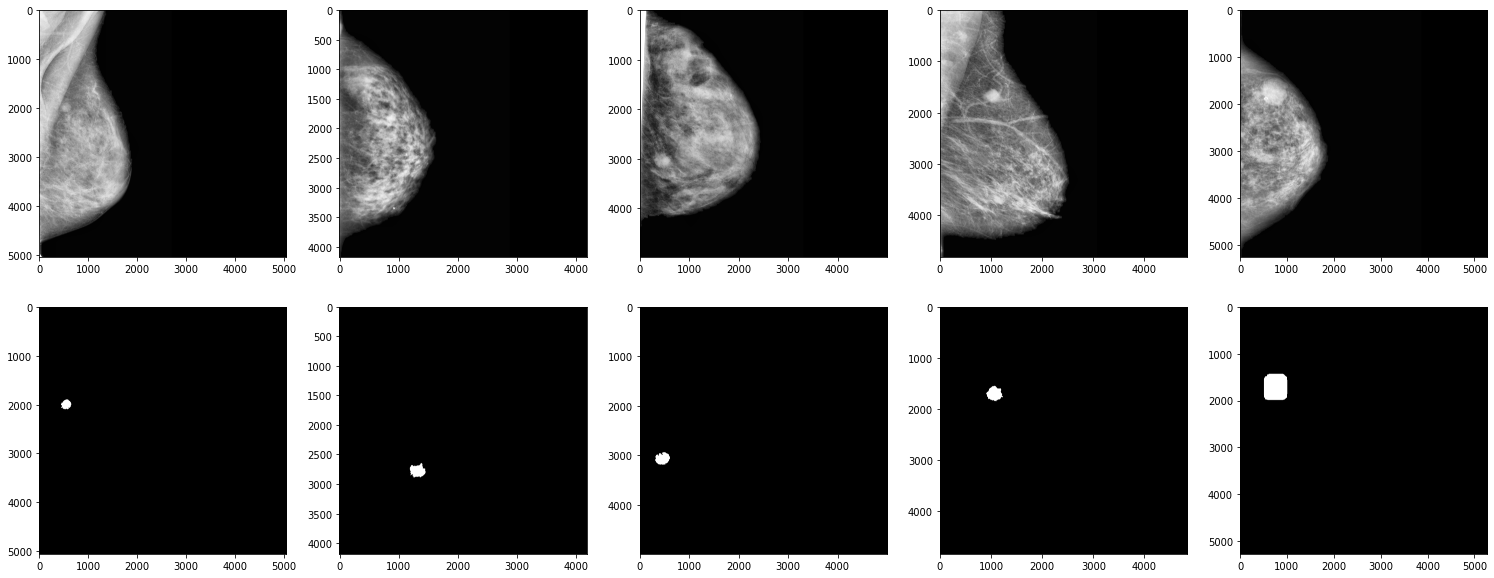

In [131]:
round_paths_full = [full_paths[identifier] for identifier in mass_shapes["ROUND"][:5]]
round_paths_mask = [mask_paths[identifier] for identifier in mass_shapes["ROUND"][:5]]

fig, ax = plt.subplots(nrows=2, ncols=len(round_paths_full), figsize=(26, 10))

for i in range(len(round_paths_full)):
    
    img = cv2.imread(round_paths_full[i], cv2.IMREAD_GRAYSCALE)
    ax[0][i].imshow(img, cmap="gray")
    
    img = cv2.imread(round_paths_mask[i], cv2.IMREAD_GRAYSCALE)
    ax[1][i].imshow(img, cmap="gray")

##### Lymph node


In [472]:
df[df["mass_shape"]=="LYMPH_NODE"]

,identifier,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,iouMetric
8,P_00106_LEFT_CC,P_00106,1,LEFT,CC,1,mass,LYMPH_NODE,CIRCUMSCRIBED,2,BENIGN_WITHOUT_CALLBACK,4,0.001249
9,P_00106_LEFT_CC,P_00106,1,LEFT,CC,2,mass,LYMPH_NODE,CIRCUMSCRIBED,2,BENIGN_WITHOUT_CALLBACK,4,0.001249
10,P_00106_LEFT_CC,P_00106,1,LEFT,CC,3,mass,LYMPH_NODE,CIRCUMSCRIBED,2,BENIGN_WITHOUT_CALLBACK,4,0.001249
19,P_00376_RIGHT_CC,P_00376,1,RIGHT,CC,1,mass,LYMPH_NODE,NaN,2,BENIGN_WITHOUT_CALLBACK,3,0.022590


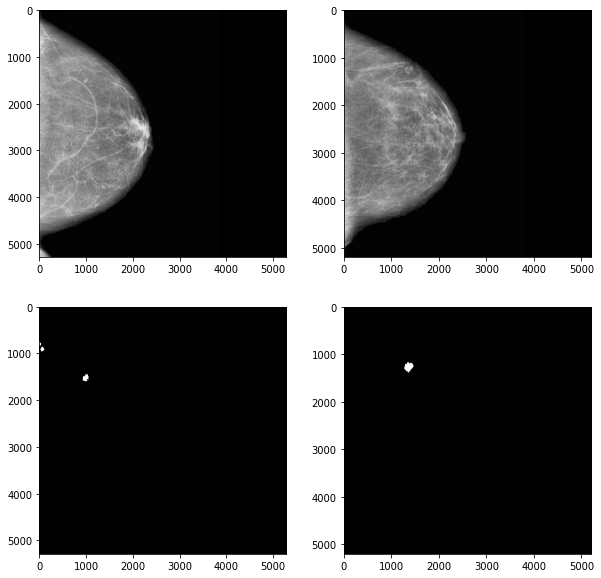

In [476]:
lymph_paths_full = [full_paths[identifier] for identifier in mass_shapes["LYMPH_NODE"]]
lymph_paths_mask = [mask_paths[identifier] for identifier in mass_shapes["LYMPH_NODE"]]

fig, ax = plt.subplots(nrows=2, ncols=len(lymph_paths_full), figsize=(10, 10))

for i in range(len(lymph_paths_full)):
    
    img = cv2.imread(lymph_paths_full[i], cv2.IMREAD_GRAYSCALE)
    ax[0][i].imshow(img, cmap="gray")
    
    img = cv2.imread(lymph_paths_mask[i], cv2.IMREAD_GRAYSCALE)
    ax[1][i].imshow(img, cmap="gray")

#### Plot distribution of IoUs for each class of mass shape

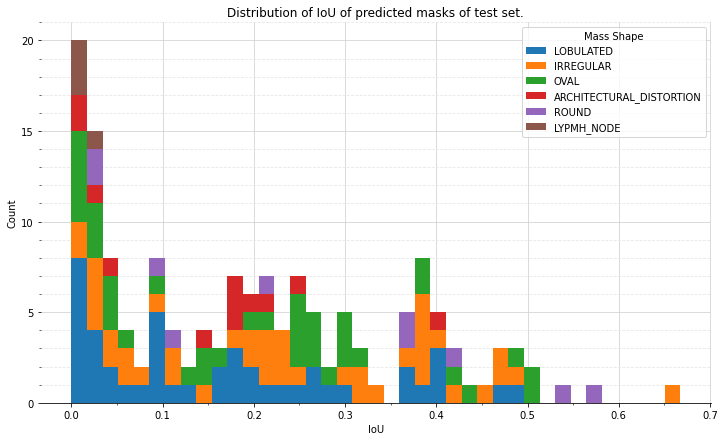

In [176]:
# Create bins for histogram
iou_max = df["iouMetric"].max()
iou_min = df["iouMetric"].min()
bins = np.linspace(start=0, stop=iou_max, num=40)

# Create separate dataframes for mass shapes
lob_df = df[df["mass_shape"]=="LOBULATED"]
irreg_df = df[df["mass_shape"]=="IRREGULAR"]
oval_df = df[df["mass_shape"]=="OVAL"]
archiDis_df = df[df["mass_shape"]=="ARCHITECTURAL_DISTORTION"]
round_df = df[df["mass_shape"]=="ROUND"]
lymph_df = df[df["mass_shape"]=="LYMPH_NODE"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
# ax.hist(df[df["mass_shape"]=="LOBULATED"]["iouMetric"], bins=bins, alpha=0.4, color="blue", edgecolor="black", label="LOBULATED")
# ax.hist(df[df["mass_shape"]=="IRREGULAR"]["iouMetric"], bins=bins, alpha=0.4, color="red", edgecolor="black", label="ROUND")
# ax.hist(df[df["mass_shape"]=="OVAL"]["iouMetric"], bins=bins, alpha=0.4, color="green", edgecolor="black", label="OVAL")

ax.hist([lob_df["iouMetric"],
         irreg_df["iouMetric"],
         oval_df["iouMetric"],
         archiDis_df["iouMetric"],
         round_df["iouMetric"],
         lymph_df["iouMetric"]], bins=bins, stacked=True, label=["LOBULATED", "IRREGULAR", "OVAL", "ARCHITECTURAL_DISTORTION", "ROUND", "LYPMH_NODE"])

ax.set_title("Distribution of IoU of predicted masks of test set.")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="y", color="#e7e7e7", linestyle="dashed")
ax.set_xlabel("IoU")
ax.set_ylabel("Count")
ax.xaxis.set_ticks(np.arange(0, 0.8, 0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_ticks(np.arange(0, 25, 5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.patch.set_alpha(0)
ax.set_axisbelow(True)

ax.legend(title="Mass Shape")

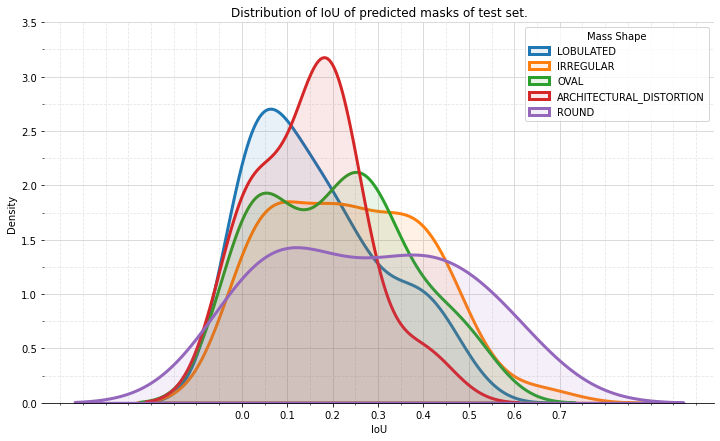

In [202]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))

# to_plot = list(df["mass_shape"].unique())
to_plot = ["LOBULATED", "IRREGULAR", "OVAL", "ARCHITECTURAL_DISTORTION", "ROUND"]

for shape in to_plot:
    
    subset = df[df["mass_shape"] == shape]
    
    sns.distplot(a=subset["iouMetric"],
                 hist=False,
                 kde=True,
                 kde_kws={"shade":True, "linewidth":3, "alpha":0.1},
                 label=shape,
                 ax=ax)
    
ax.set_title("Distribution of IoU of predicted masks of test set.")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="both", color="#e7e7e7", linestyle="dashed")
ax.set_xlabel("IoU")
ax.set_ylabel("Density")
ax.xaxis.set_ticks(np.arange(0, 0.8, 0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_ticks(np.arange(0, 4, 0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.patch.set_alpha(0)
ax.set_axisbelow(True)

ax.legend(title="Mass Shape")

CHECK skewness across mass shapes

from image predictinos, what is passable iou.

### Q2: Is IoU necessarily bad?

In [414]:
# Rename overlay files to include IOU scores.

directory = "../results/fit/20201203_040325___INSTANCE/predicted_outputs/overlays_full"

for f in os.listdir(directory):
    
    if f.endswith(".png"):
        
        f_split = f.split("_")
        identifier = "_".join(f_split[:4])
        
        # Get first occuring row index
        row_index = df.index[df["identifier"] == identifier][0]
        
        # Get IOU
        iou = df.loc[row_index, "iouMetric"]
        iou = round(iou, 4)
        
        # Create new filename
        f_new = f.replace(".png", f"___{iou}.png")
        new_name = os.path.join(directory, f_new)
        
        # Rename
        old_name = os.path.join(directory, f)
        os.rename(old_name, new_name)

In [523]:
df.sort_values(by=["iouMetric"], ascending=True).head(10)

,identifier,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,iouMetric
106,P_01532_LEFT_MLO,P_01532,1,LEFT,MLO,1,mass,LOBULATED,CIRCUMSCRIBED,4,BENIGN,3,3.145529e-18
154,P_01213_LEFT_MLO,P_01213,2,LEFT,MLO,1,mass,LOBULATED,ILL_DEFINED,4,MALIGNANT,3,4.201117e-18
11,P_00109_LEFT_CC,P_00109,3,LEFT,CC,1,mass,LOBULATED,ILL_DEFINED,4,BENIGN,1,4.626292e-18
49,P_00778_RIGHT_CC,P_00778,3,RIGHT,CC,2,mass,ARCHITECTURAL_DISTORTION,NaN,2,BENIGN,3,1.824226e-04
48,P_00778_RIGHT_CC,P_00778,3,RIGHT,CC,1,mass,ARCHITECTURAL_DISTORTION,NaN,2,BENIGN,3,1.824226e-04
8,P_00106_LEFT_CC,P_00106,1,LEFT,CC,1,mass,LYMPH_NODE,CIRCUMSCRIBED,2,BENIGN_WITHOUT_CALLBACK,4,1.248934e-03
10,P_00106_LEFT_CC,P_00106,1,LEFT,CC,3,mass,LYMPH_NODE,CIRCUMSCRIBED,2,BENIGN_WITHOUT_CALLBACK,4,1.248934e-03
9,P_00106_LEFT_CC,P_00106,1,LEFT,CC,2,mass,LYMPH_NODE,CIRCUMSCRIBED,2,BENIGN_WITHOUT_CALLBACK,4,1.248934e-03
26,P_00421_LEFT_MLO,P_00421,1,LEFT,MLO,1,mass,LOBULATED,CIRCUMSCRIBED,3,BENIGN,5,1.805046e-03
62,P_01018_RIGHT_MLO,P_01018,4,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,3,BENIGN_WITHOUT_CALLBACK,4,2.087932e-03


### Q2: Which mass shapes dominate (if any) the 20th and 80th percentile IoUs?


In [181]:
df_sorted = df.sort_values(by=["iouMetric"], ascending=False)

In [191]:
df_sorted.head(10)

,identifier,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,iouMetric
71,P_01138_RIGHT_CC,P_01138,1,RIGHT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,5,0.667243
153,P_01204_RIGHT_MLO,P_01204,1,RIGHT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,0.655128
79,P_01225_RIGHT_CC,P_01225,2,RIGHT,CC,1,mass,ROUND,MICROLOBULATED,4,BENIGN,5,0.579977
109,P_01567_LEFT_MLO,P_01567,3,LEFT,MLO,1,mass,ROUND,MICROLOBULATED,3,BENIGN,5,0.532677
112,P_01596_RIGHT_MLO,P_01596,2,RIGHT,MLO,2,mass,OVAL,ILL_DEFINED,4,MALIGNANT,5,0.506861
111,P_01596_RIGHT_MLO,P_01596,2,RIGHT,MLO,1,mass,OVAL,ILL_DEFINED,4,MALIGNANT,5,0.506861
87,P_01343_LEFT_CC,P_01343,2,LEFT,CC,2,mass,IRREGULAR,ILL_DEFINED-SPICULATED,4,MALIGNANT,5,0.495915
86,P_01343_LEFT_CC,P_01343,2,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,5,MALIGNANT,5,0.495915
67,P_01082_RIGHT_MLO,P_01082,1,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,0.488231
22,P_00399_RIGHT_CC,P_00399,1,RIGHT,CC,1,mass,LOBULATED,MICROLOBULATED,5,MALIGNANT,5,0.479470


In [192]:
# Top 20 percentile IoUs.
df_80pct =  df[df["iouMetric"] >= df["iouMetric"].quantile(.80)].sort_values(by=["iouMetric"], ascending=False)

# Bottom 20 percentile IoUs.
df_20pct =  df[df["iouMetric"] <= df["iouMetric"].quantile(.20)].sort_values(by=["iouMetric"], ascending=False)

In [457]:
# Create empty dataframe.
left = df["mass_shape"].value_counts().to_frame()
left.rename(columns={"mass_shape":"total"}, inplace=True)

right = df_80pct["mass_shape"].value_counts().to_frame()
right.rename(columns={"mass_shape":"num_above_80pct"}, inplace=True)

result_80pct = pd.merge(left=left, right=right, how="left", left_index=True, right_index=True)
result_80pct["num_above_80pct"] = result_80pct["num_above_80pct"].fillna(0)

result_80pct["ratio"] = (result_80pct["num_above_80pct"] / result_80pct["total"]) * 100

result_80pct.sort_values(by=["ratio"], ascending=False, inplace=True)

result_80pct

,total,num_above_80pct,ratio
ROUND-OVAL,2,2.0,100.000000
IRREGULAR-ARCHITECTURAL_DISTORTION,9,4.0,44.444444
ROUND,10,3.0,30.000000
IRREGULAR,42,11.0,26.190476
OVAL,38,7.0,18.421053
LOBULATED,45,6.0,13.333333
ARCHITECTURAL_DISTORTION,12,1.0,8.333333
LYMPH_NODE,4,0.0,0.000000
ASYMMETRIC_BREAST_TISSUE,3,0.0,0.000000
LOBULATED-IRREGULAR,1,0.0,0.000000


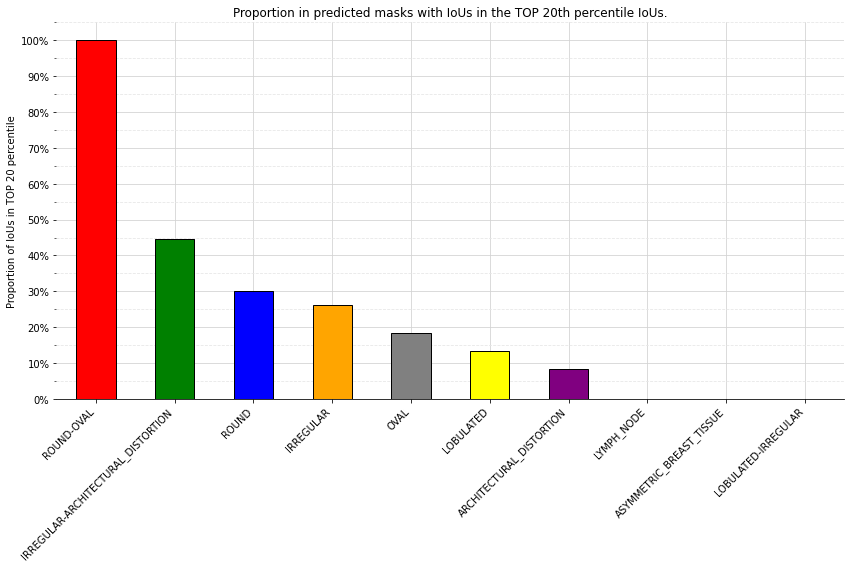

In [520]:
# Create colours.
color_list = ["red", "green", "blue", "orange", "gray", "yellow", "purple", "brown", "pink", "white"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax = result_80pct["ratio"].plot.bar(x="mass_shape", color=color_list, edgecolor="black")

ax.set_title("Proportion in predicted masks with IoUs in the TOP 20th percentile IoUs.")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="y", color="#e7e7e7", linestyle="dashed")
# ax.set_xlabel("IoU")
ax.set_ylabel("Proportion of IoUs in TOP 20 percentile")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.yaxis.set_ticks(np.arange(0, 110, 10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
ax.patch.set_alpha(0)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(fname="../writeups/visualisations_for_slides/80pct_colour.png", dpi=300)

In [460]:
# Create empty dataframe.
left = df["mass_shape"].value_counts().to_frame()
left.rename(columns={"mass_shape":"total"}, inplace=True)

right = df_20pct["mass_shape"].value_counts().to_frame()
right.rename(columns={"mass_shape":"num_below_20pct"}, inplace=True)

result_20pct = pd.merge(left=left, right=right, how="left", left_index=True, right_index=True)
result_20pct["num_below_20pct"] = result_20pct["num_below_20pct"].fillna(0)

result_20pct["ratio"] = (result_20pct["num_below_20pct"] / result_20pct["total"]) * 100

result_20pct.sort_values(by=["ratio"], ascending=False, inplace=True)

result_20pct

,total,num_below_20pct,ratio
LYMPH_NODE,4,4.0,100.000000
LOBULATED,45,12.0,26.666667
OVAL,38,8.0,21.052632
ROUND,10,2.0,20.000000
ARCHITECTURAL_DISTORTION,12,2.0,16.666667
IRREGULAR,42,5.0,11.904762
IRREGULAR-ARCHITECTURAL_DISTORTION,9,1.0,11.111111
ASYMMETRIC_BREAST_TISSUE,3,0.0,0.000000
ROUND-OVAL,2,0.0,0.000000
LOBULATED-IRREGULAR,1,0.0,0.000000


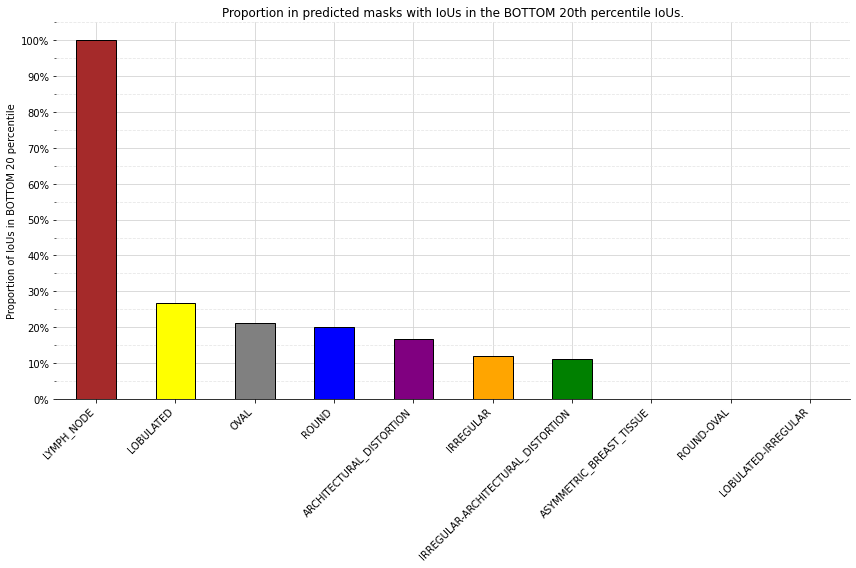

In [521]:
# Create colours.
color_list = ["brown", "yellow", "gray", "blue", "purple", "orange", "green", "pink", "red", "white"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax = result_20pct["ratio"].plot.bar(x="mass_shape", color=color_list, edgecolor="black")

ax.set_title("Proportion in predicted masks with IoUs in the BOTTOM 20th percentile IoUs.")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="y", color="#e7e7e7", linestyle="dashed")
# ax.set_xlabel("IoU")
ax.set_ylabel("Proportion of IoUs in BOTTOM 20 percentile")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.yaxis.set_ticks(np.arange(0, 110, 10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
ax.patch.set_alpha(0)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(fname="../writeups/visualisations_for_slides/20pct_colour.png", dpi=300)